Exploring missing data

In [557]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a pandas DataFrame
file_path = '/Users/Isha/Desktop/TUe/Year 3/Quarter 1 Y3/Data Challenge 3/DC3/data/food_crises_updated.csv'
df = pd.read_csv(file_path)
print(len(df))

12324


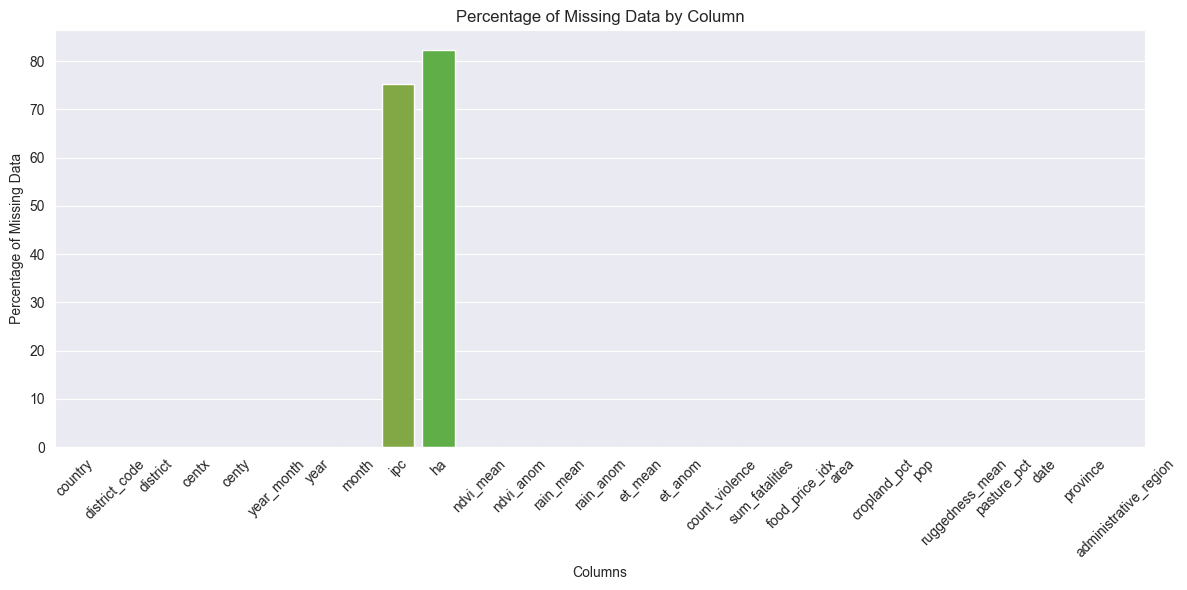

In [558]:
# Calculate the percentage of missing data for each column
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Plot the missing data percentages
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_percentage.index, y=missing_percentage.values)
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Data')
plt.title('Percentage of Missing Data by Column')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The plot above shows that approximately 75% of IPC data is missing and 80% of humanitarian assitance is missing

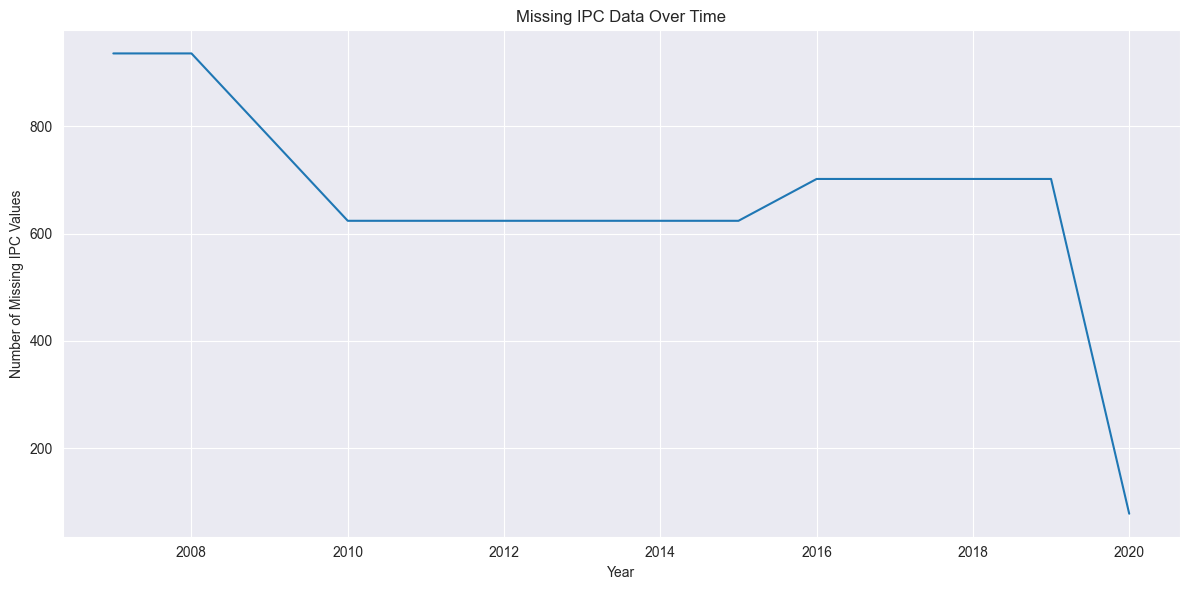

In [559]:
# Check missing data pattern for a specific column (e.g., 'IPC')
# Assuming 'IPC' is the column containing IPC data
ipc_missing_pattern = df['ipc'].isnull().sum()

# Analyze the pattern further, consider time-based analysis
# Example: Check if missing data has a pattern linearly with time
# Assuming a time-related column (e.g., 'date')
# Replace 'date' with the actual time-related column in dataset
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# Group by year and count missing IPC values for each year
missing_by_year = df.groupby('year')['ipc'].apply(lambda x: x.isnull().sum())

# Plot the missing data pattern over time
plt.figure(figsize=(12, 6))
sns.lineplot(x=missing_by_year.index, y=missing_by_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Missing IPC Values')
plt.title('Missing IPC Data Over Time')
plt.tight_layout()
plt.show()

The above graph shows missing data for the IPC values over the years. The graph shows a non-linear trend. Given below is the same exploration but for every 3 months, instead of a very so that we get a more granular picture:

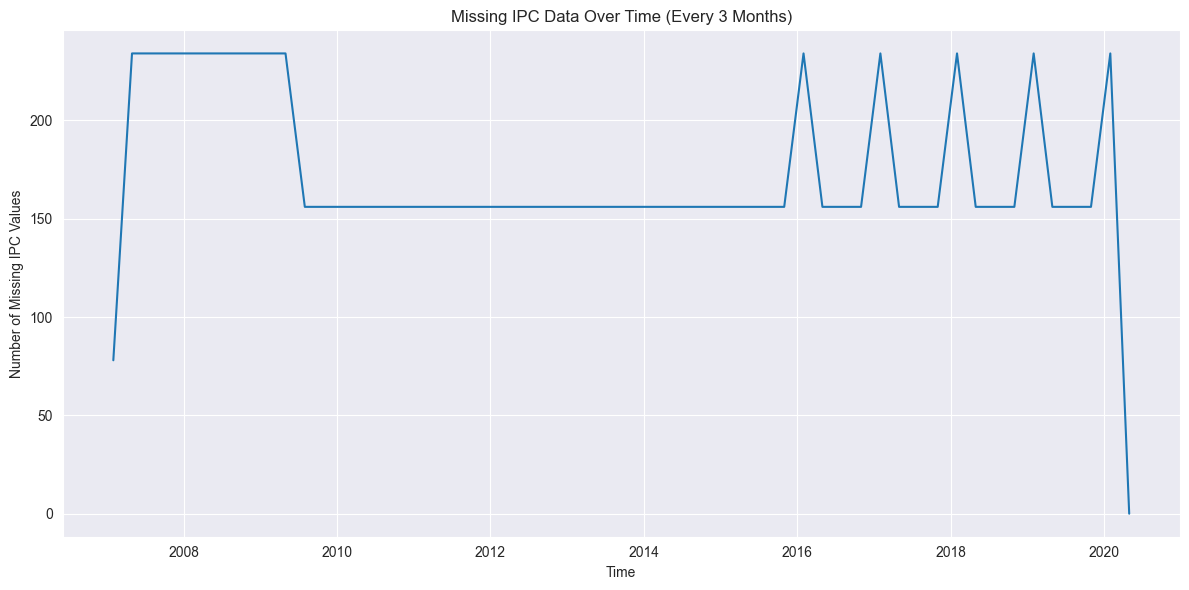

In [560]:
ipc_column = 'ipc'

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Resample data to 3-month intervals and count missing IPC values for each interval
missing_by_3months = df[ipc_column].resample('3M').apply(lambda x: x.isnull().sum())

# Plot the missing data pattern over time for every 3 months
plt.figure(figsize=(12, 6))
sns.lineplot(x=missing_by_3months.index, y=missing_by_3months.values)
plt.xlabel('Time')
plt.ylabel('Number of Missing IPC Values')
plt.title('Missing IPC Data Over Time (Every 3 Months)')
plt.tight_layout()
plt.show()


There seem to be significant differences between the graphs for each year VS over every 3 months. Not sure why this is happening and what is causing it but maybe there are short-Term Fluctuations: Analyzing missing data at a more granular level, such as every 3 months, can reveal short-term fluctuations or anomalies that might not be apparent in a yearly analysis. These fluctuations could be related to specific events, changes in data collection procedures, or other short-term factors affecting data reporting.

If the patterns are significantly different, it's essential to investigate the underlying reasons for these differences. Understanding the context of the data, data collection methodologies, external events, or changes in reporting practices can provide insights into why the missing data patterns vary at different time scales

Creating a correlation heatmap requires having numerical data, and it's typically used to visualize the correlation between numerical features in a dataset. By doing this, I am trying to find how strongly the presence or absence of one variable (IPC) affects the presence of another.

In [561]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a pandas DataFrame
file_path = '/Users/Isha/Desktop/TUe/Year 3/Quarter 1 Y3/Data Challenge 3/DC3/data/food_crises_updated.csv'
df = pd.read_csv(file_path)

# Select columns with numerical data types
numerical_columns = df.select_dtypes(include=['number']).columns

# Print the numerical column names
print("Numerical columns:")
print(numerical_columns)

print(df.columns)
unique_regions = df['administrative_region'].unique()
print('Unique administrative regions:', unique_regions)


Numerical columns:
Index(['district_code', 'centx', 'centy', 'year', 'month', 'ipc', 'ha',
       'ndvi_mean', 'ndvi_anom', 'rain_mean', 'rain_anom', 'et_mean',
       'et_anom', 'count_violence', 'sum_fatalities', 'food_price_idx', 'area',
       'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct'],
      dtype='object')
Index(['country', 'district_code', 'district', 'centx', 'centy', 'year_month',
       'year', 'month', 'ipc', 'ha', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
       'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
       'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
       'pasture_pct', 'date', 'province', 'administrative_region'],
      dtype='object')
Unique administrative regions: ['Greater Upper Nile' 'Bahr El Ghazal' 'Equatoria']


In [562]:
## GREAT UPPER NILE
# Print the first 10 rows of 'district_code' and 'administrative_region' columns
#print(df.loc[:, ['district_code', 'administrative_region']].head(10))

# Initialize a set to store district codes for Greater Upper Nile (ensures uniqueness)
district_codes_nile_set = set()

# Iterate through the DataFrame
for index, row in df.iterrows():
    if row['administrative_region'] == 'Greater Upper Nile':
        district_codes_nile_set.add(row['district_code'])

# Convert the set back to a list (to maintain the original list data type)
district_codes_in_nile = list(district_codes_nile_set)

# Print the unique district codes in Greater Upper Nile
print('Unique District codes in Greater Upper Nile:', district_codes_in_nile)

Unique District codes in Greater Upper Nile: [130, 134, 135, 136, 137, 138, 139, 140, 142, 143, 144, 146, 147, 148, 149, 150, 151, 74, 104, 109, 111, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 127]


In [563]:
## BAHR EL GHAZAL

# Initialize a set to store district codes for Bahr El Ghazal (ensures uniqueness)
district_codes_bahr_set = set()

# Iterate through the DataFrame
for index, row in df.iterrows():
    if row['administrative_region'] == 'Bahr El Ghazal':
        district_codes_bahr_set.add(row['district_code'])

# Convert the set back to a list (to maintain the original list data type)
district_codes_in_bahr = list(district_codes_bahr_set)

# Print the unique district codes in Bahr El Ghazal
print('Unique District codes in Bahr El Ghazal:', district_codes_in_bahr)


Unique District codes in Bahr El Ghazal: [128, 129, 131, 132, 133, 141, 145, 75, 76, 99, 101, 103, 105, 106, 107, 108, 110, 112, 113, 117, 125, 126]


In [564]:
## EQUATORIA
# Initialize a set to store district codes for Equatoria (ensures uniqueness)
district_codes_eq_set = set()

# Iterate through the DataFrame
for index, row in df.iterrows():
    if row['administrative_region'] == 'Equatoria':
        district_codes_eq_set.add(row['district_code'])

# Convert the set back to a list (to maintain the original list data type)
district_codes_in_eq = list(district_codes_eq_set)

# Print the unique district codes in Equatoria
print('Unique District codes in Equatoria:', district_codes_in_eq)


Unique District codes in Equatoria: [77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 102]


From all the numerical columns, choosing the following for the correlation heatmap:
district_code, year, month, ipc, ha, ndvi_mean, ndvi_anom, rain_mean, rain_anom, count_violence, food_price_idx, pop, sum_fatalities

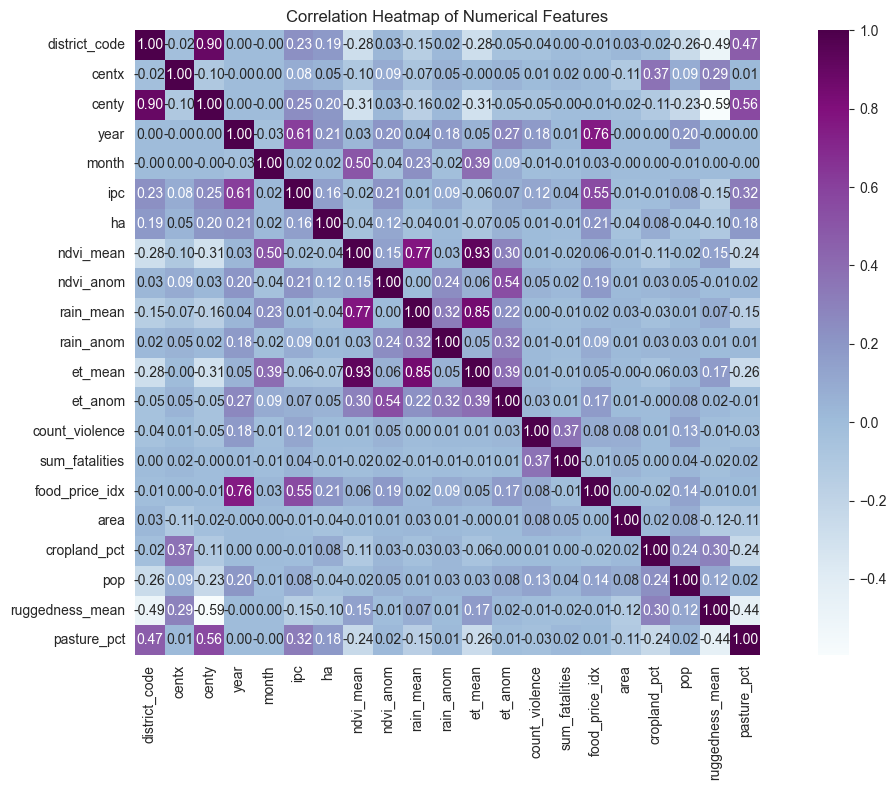

In [565]:
# Assuming you have numerical columns other than 'IPC'
# Replace with the actual numerical columns from your dataset
numerical_columns = ['district_code', 'centx', 'centy', 'year', 'month', 'ipc', 'ha',
       'ndvi_mean', 'ndvi_anom', 'rain_mean', 'rain_anom', 'et_mean',
       'et_anom', 'count_violence', 'sum_fatalities', 'food_price_idx', 'area',
       'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct']


# Subset the DataFrame to include only numerical columns
numerical_df = df[numerical_columns]

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='BuPu', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()


**Correlation of IPC with district-code: 0.23 ->positive but relatively weak correlation**

**Correlation of IPC with year: 0.61 ->strong postive correlation, suggesting a general upward trend or a time-related pattern.**

Correlation of IPC with month: 0.02 ->a very weak positive correlation, little to no discernible monthly pattern in IPC values.

Correlation of IPC with ipc: 1 ->expected

Correlation of IPC with humanitarian aid: 0.16 ->positive but relatively weak correlation

Correlation of IPC with ndvi_mean: -0.02 ->very weak negative correlation, little to no linear relationship between these two variables.

Correlation of IPC with ndvi_anomalies: 0.21 ->positive but relatively weak correlation

Correlation of IPC with rain-mean: 0.01 ->weak positive correlation

Correlation of IPC with rain-anomalies: 0.09 ->positive but relatively weak correlation

Correlation of IPC with count_violence: 0.12 ->positive but relatively weak correlation

Correlation of IPC with sum_fatalities: 0.04 ->positive but relatively weak correlation

**Correlation of IPC with food_price_index: 0.55 ->strong positive correlation, indicates that as the food price index increases, IPC also tends to increase, suggesting a strong relationship between food prices and food security.**

Correlation of IPC with population: 0.08 ->very weak positive correlation, little to no linear relationship between IPC and the population size of the region.

**Correlation of IPC with pasture_pct: 0.32 -> positive but relatively weak correlation. Indictates that the occurence of farmland is somewhat correlated to the ipc scores. However, if there is greater farmland then the ipc scores should be lower - WHY IS THIS HAPPENING?**



In [566]:
## creating a correlation matrix for Region 1: Greater Upper Nile
greater_upper_nile = df[df['administrative_region'] == 'Greater Upper Nile']
#print(greater_upper_nile.head())

# Calculate the correlation matrix for Region 1: Greater Upper Nile
correlation_matrix_nile = greater_upper_nile.corr()

correlation_matrix_nile['ipc']

district_code     -0.073789
centx             -0.099228
centy             -0.131567
year               0.636702
month              0.036787
ipc                1.000000
ha                 0.014138
ndvi_mean          0.159314
ndvi_anom          0.283401
rain_mean          0.155415
rain_anom          0.145341
et_mean            0.099447
et_anom            0.082940
count_violence     0.100809
sum_fatalities     0.043597
food_price_idx     0.488236
area               0.020064
cropland_pct      -0.085547
pop                0.155297
ruggedness_mean   -0.050628
pasture_pct        0.153195
Name: ipc, dtype: float64

In [567]:
## creating a correlation matrix for Region 2: Bahr El Ghazal
bahr_el_ghazal = df[df['administrative_region'] == 'Bahr El Ghazal']

# Calculate the correlation matrix for Region 2: Bahr El Ghazal
correlation_matrix_bahr = bahr_el_ghazal.corr()

correlation_matrix_bahr['ipc']

district_code      0.076627
centx             -0.075184
centy              0.169134
year               0.633606
month              0.036800
ipc                1.000000
ha                 0.180086
ndvi_mean          0.086325
ndvi_anom          0.124932
rain_mean          0.158888
rain_anom          0.129263
et_mean            0.078412
et_anom            0.114314
count_violence     0.091983
sum_fatalities    -0.047433
food_price_idx     0.602395
area              -0.067577
cropland_pct       0.146773
pop                0.234691
ruggedness_mean   -0.109764
pasture_pct        0.123272
Name: ipc, dtype: float64

In [568]:
## creating a correlation matrix for Region 3: Equatoria
equatoria = df[df['administrative_region'] == 'Equatoria']

# Calculate the correlation matrix for Region 3: Equatoria
correlation_matrix_equatoria = equatoria.corr()

correlation_matrix_equatoria['ipc']

district_code      0.076613
centx              0.311179
centy             -0.041526
year               0.664034
month             -0.010740
ipc                1.000000
ha                 0.160484
ndvi_mean         -0.148691
ndvi_anom          0.122580
rain_mean         -0.110516
rain_anom          0.009112
et_mean           -0.105088
et_anom            0.038208
count_violence     0.186081
sum_fatalities     0.151902
food_price_idx     0.700130
area               0.073100
cropland_pct       0.213106
pop                0.164045
ruggedness_mean    0.051495
pasture_pct        0.266323
Name: ipc, dtype: float64

**Those metric worth looking at from the exploration above are district code, year, food-price-index, pasture_pct**
Starting food price index with the following approach:
1. find trend for food price index over the years
2. mine news articles for why it behaves the way it does (goes up linearly, patterns, trends, etc) - sentiment analysis
3. use SLE angles to justify and gives us a direction for further reserach

The FAO Food Price Index is a measure of the monthly change in international prices of a basket of food commodities.

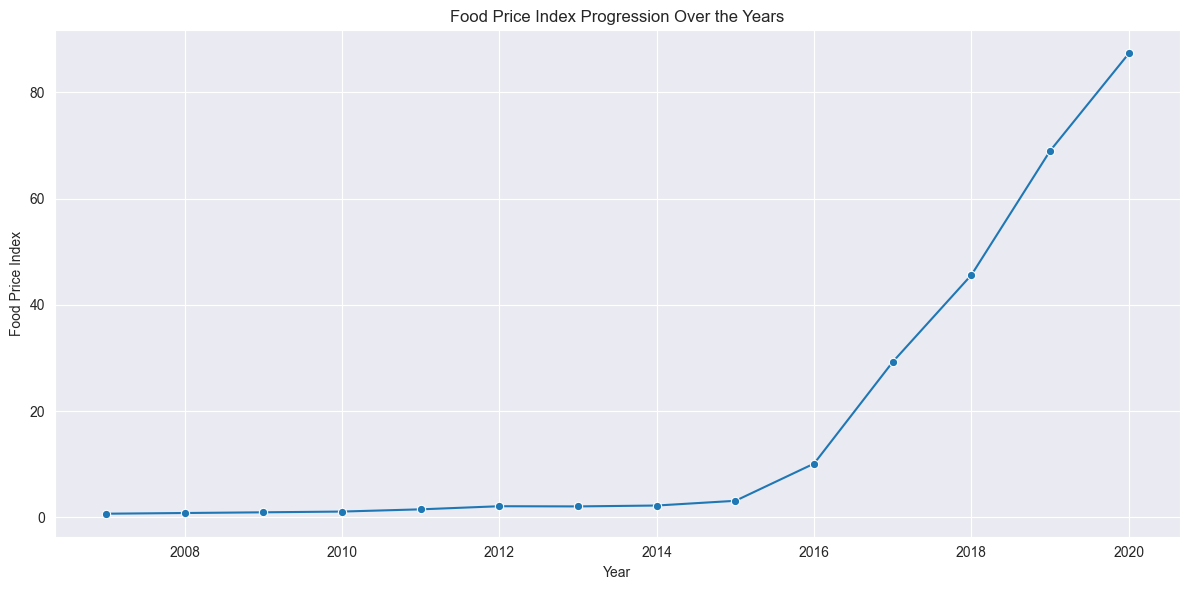

In [569]:
food_price_column = 'food_price_idx'

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Extract year and month from the 'date' column
df['year'] = df['date'].dt.year

# Group by year and calculate the mean food price index for each year
food_price_by_year = df.groupby('year')[food_price_column].mean()

# Plot the food price index over the years
plt.figure(figsize=(12, 6))
sns.lineplot(x=food_price_by_year.index, y=food_price_by_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Food Price Index')
plt.title('Food Price Index Progression Over the Years')
plt.tight_layout()
plt.show()

Look for indicators as to why the food prices have been exponentially escalating since 2015 by mining the news articles, using external news data, and carrying out research:

1. Cyclical Relationship:

This correlation suggests a cyclical relationship: economic factors can influence food prices, which in turn affect food security. When food prices are high, households may struggle to afford sufficient food, leading to increased food insecurity. Conversely, during times of economic stability or lower food prices, food security might improve.

2. Policy and Interventions:

Recognizing the strong correlation between food price index and food insecurity, policymakers and organizations can design interventions to address both aspects simultaneously. This could include measures to stabilize food prices, improve income levels, provide safety nets for vulnerable populations, or enhance agricultural production to increase food availability and affordability.

In [570]:
# Group by year and calculate the mean food price index for each year
food_price_by_year_nile = greater_upper_nile.groupby('year')[food_price_column].mean()

#print(food_price_by_year_nile)
"""
# Plot the food price index over the years
plt.figure(figsize=(12, 6))
sns.lineplot(x=food_price_by_year_nile.index, y=food_price_by_year_nile.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Food Price Index')
plt.title('Food Price Index Progression Over the Years in Greater Upper Nile')
plt.tight_layout()
plt.show()
"""
# Group by year and calculate the mean food price index for each year
food_price_by_year_bahr = bahr_el_ghazal.groupby('year')[food_price_column].mean()

#print(food_price_by_year_bahr)
"""
# Plot the food price index over the years
plt.figure(figsize=(12, 6))
sns.lineplot(x=food_price_by_year_bahr.index, y=food_price_by_year_bahr.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Food Price Index')
plt.title('Food Price Index Progression Over the Years in Bahr El Ghazal')
plt.tight_layout()
plt.show()
"""
# Group by year and calculate the mean food price index for each year
food_price_by_year_equatoria = equatoria.groupby('year')[food_price_column].mean()

#print(food_price_by_year_equatoria)
"""
# Plot the food price index over the years
plt.figure(figsize=(12, 6))
sns.lineplot(x=food_price_by_year_equatoria.index, y=food_price_by_year_equatoria.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Food Price Index')
plt.title('Food Price Index Progression Over the Years in Equatoria')
plt.tight_layout()
plt.show()
"""

"\n# Plot the food price index over the years\nplt.figure(figsize=(12, 6))\nsns.lineplot(x=food_price_by_year_equatoria.index, y=food_price_by_year_equatoria.values, marker='o')\nplt.xlabel('Year')\nplt.ylabel('Food Price Index')\nplt.title('Food Price Index Progression Over the Years in Equatoria')\nplt.tight_layout()\nplt.show()\n"

See Progression of food price indexes in all 3 regions side by side

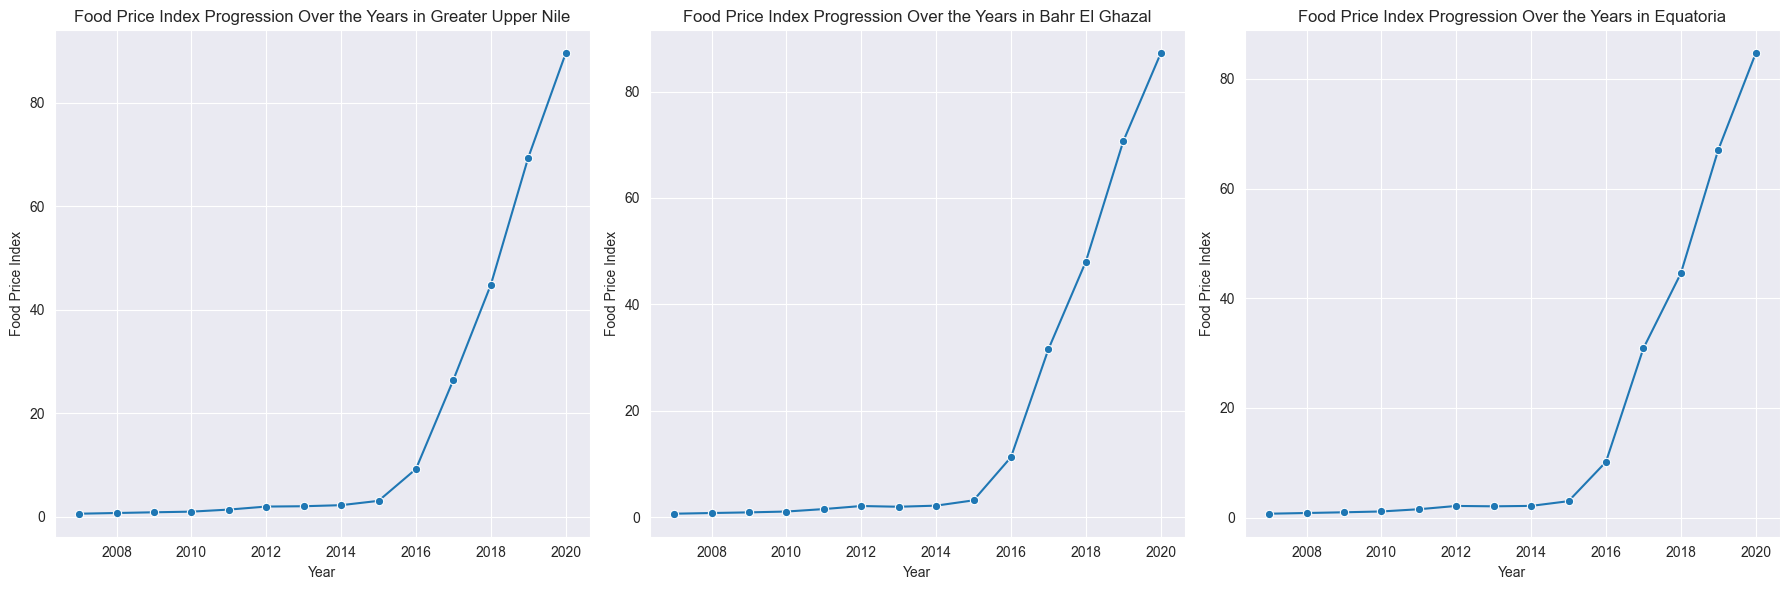

In [571]:
## See Progression of food price indexes in all 3 regions side by side
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for Great Upper Nile
sns.lineplot(ax=axes[0], x=food_price_by_year_nile.index, y=food_price_by_year_nile.values, marker='o')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Food Price Index')
axes[0].set_title('Food Price Index Progression Over the Years in Greater Upper Nile')

# Plot for Bahr El Ghazal
sns.lineplot(ax=axes[1], x=food_price_by_year_bahr.index, y=food_price_by_year_bahr.values, marker='o')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Food Price Index')
axes[1].set_title('Food Price Index Progression Over the Years in Bahr El Ghazal')

# Plot for Equatoria
sns.lineplot(ax=axes[2], x=food_price_by_year_equatoria.index, y=food_price_by_year_equatoria.values, marker='o')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Food Price Index')
axes[2].set_title('Food Price Index Progression Over the Years in Equatoria')

plt.tight_layout()
plt.show()


It can be observed that all 3 regions have a very similar increasing trend in the food price index over the years starting 2015. There are however, subtle difference between the 3 regions. For example, Equatoria has a slightly steeper climb in prices from 2016 to 2017. Although these are subtle difference, they may contribute to getting a better understanding of which regions are more affected or whether they are all the same. This can only be proven by further analysis.

Additionally, these graphs show that our hypothesis that some regions might have been more affected that other in terms of the resulting food price index gets negated. That is, the effect of policies/lack of distribution & aid, etc seems common for all 3 regions, and not in favor of any.

For regression imputation, we will use a regression analysis to predict missing IPC values based on other variables (in this case, the other variables were chosen from those most correlated with IPC - year, district_code, food_price_idx, pasture_pct). We will also do it for each administrative region separately so that the accuracy is better.

Earlier, I made 3 lists (district_code_in_nile, district_code_in_bahr, district_code_in_eq) to store all the unique district codes that fall under the 3 administrative regions. So, I will be using those to impute for each region separately

High level approach:
1) Data preparation
Create separate DataFrames for each administrative region based on the unique district codes for that region.
Select the relevant columns for regression imputation (year, food_price_idx, pasture_pct, ipc).
Drop rows with missing IPC values (as you'll be predicting these).

2) Regression Imputation

3) Create a dataframe: Replace missing values from dataframe with predicted values

4) Repeat for Each Administrative Region

Regression Imputation for Greater Upper Nile:

In [572]:
from sklearn.linear_model import LinearRegression

## REGRESSION IMPUTATION IN GREATER UPPER NILE:

#print('Unique District codes in Greater Upper Nile:',district_codes_in_nile)
# Filter the DataFrame for the Greater Upper Nile region
greater_upper_nile_df = df[df['district_code'].isin(district_codes_in_nile)]
#print(greater_upper_nile_df)

# Select relevant columns for regression imputation
selected_features = ['year', 'food_price_idx', 'pasture_pct', 'ipc']

# Drop rows with missing IPC values since that is what we are going to predict
greater_upper_nile_df.dropna(subset=['ipc'], inplace=True)

# Prepare features (X) and target (y) for regression
X_nile = greater_upper_nile_df[selected_features[:-1]]  # Features (excluding IPC)
y_nile = greater_upper_nile_df['ipc']  # Target variable (IPC)

# Train a regression model
model_nile = LinearRegression()
model_nile.fit(X_nile, y_nile)

# Identify rows with missing IPC values
missing_ipc_rows = df['ipc'].isnull() & df['administrative_region'].eq('Greater Upper Nile')

# Predict missing IPC values based on available features
predicted_ipc_values = model_nile.predict(df.loc[missing_ipc_rows, selected_features[:-1]])

"""
# Update the DataFrame with the predicted IPC values
df.loc[missing_ipc_rows, 'ipc'] = predicted_ipc_values

# Print the DataFrame to verify the changes
print(df)
"""

# Create a new DataFrame with the predicted IPC values
predicted_df_nile = df.copy()  # Create a copy of the original DataFrame
predicted_df_nile.loc[missing_ipc_rows, 'ipc'] = predicted_ipc_values  # Update IPC with predicted values

# Print the new DataFrame with predicted IPC values
#print(predicted_df_nile)
print(predicted_df_nile['ipc'].head)


<bound method NDFrame.head of 0        1.168975
1        1.168968
2        1.168920
3        1.168896
4        1.168873
           ...   
12319    3.000000
12320    3.226463
12321    3.216000
12322    3.386223
12323    4.000000
Name: ipc, Length: 12324, dtype: float64>


/var/folders/_f/7jgfw7qx5jn8xl64g_9px9g00000gp/T/ipykernel_27432/1451065564.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  greater_upper_nile_df.dropna(subset=['ipc'], inplace=True)


In [573]:
# After filling in the predicted values, Check if there are still any missing values in the 'ipc' column of the new df
ipc_missing = predicted_df_nile['ipc'].isnull().any()
# Print the result
print('Are there any missing values in the IPC column?', ipc_missing)
# Count the number of rows with missing values in the 'ipc' column
missing_ipc_count = predicted_df_nile['ipc'].isnull().sum()
# Print the count
print('Number of rows with missing IPC values:', missing_ipc_count)


Are there any missing values in the IPC column? True
Number of rows with missing IPC values: 5474


There are still missing values after the imputation. I'm not sure why this is happening.

Regression Imputation for Bahr El Ghazal:

In [574]:
## REGRESSION IMPUTATION IN BAHR EL GHAZAL:

print('Unique District codes in Bahr El Ghazal:', district_codes_in_bahr)
# Filter the DataFrame for the Bahr El Ghazal region
bahr_el_ghazal_df = df[df['district_code'].isin(district_codes_in_bahr)]

# Select relevant columns for regression imputation
selected_features = ['year', 'food_price_idx', 'pasture_pct', 'ipc']

# Drop rows with missing IPC values since that is what we are going to predict
bahr_el_ghazal_df.dropna(subset=['ipc'], inplace=True)

# Prepare features (X) and target (y) for regression
X = bahr_el_ghazal_df[selected_features[:-1]]  # Features (excluding IPC)
y = bahr_el_ghazal_df['ipc']  # Target variable (IPC)

# Train a regression model
model_bahr = LinearRegression()
model_bahr.fit(X, y)

# Identify rows with missing IPC values in the Bahr El Ghazal region
missing_ipc_rows_bahr = df['ipc'].isnull() & (df['administrative_region'] == 'Bahr El Ghazal')

# Predict missing IPC values based on available features
predicted_ipc_values_bahr = model_bahr.predict(df.loc[missing_ipc_rows_bahr, selected_features[:-1]])

# Create a new DataFrame with the predicted IPC values for Bahr El Ghazal
predicted_df_bahr = df.copy()  # Create a copy of the original DataFrame
predicted_df_bahr.loc[missing_ipc_rows_bahr, 'ipc'] = predicted_ipc_values_bahr  # Update IPC with predicted values

# Print the new DataFrame with predicted IPC values for Bahr El Ghazal
print(predicted_df_bahr['ipc'].head())



Unique District codes in Bahr El Ghazal: [128, 129, 131, 132, 133, 141, 145, 75, 76, 99, 101, 103, 105, 106, 107, 108, 110, 112, 113, 117, 125, 126]
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: ipc, dtype: float64


/var/folders/_f/7jgfw7qx5jn8xl64g_9px9g00000gp/T/ipykernel_27432/1334395693.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bahr_el_ghazal_df.dropna(subset=['ipc'], inplace=True)


In [575]:
# After filling in the predicted values, Check if there are still any missing values in the 'ipc' column of the new df
ipc_missing_bahr = predicted_df_bahr['ipc'].isnull().any()
# Print the result
print('Are there any missing values in the IPC column?', ipc_missing_bahr)
# Count the number of rows with missing values in the 'ipc' column
missing_ipc_count_bahr = predicted_df_bahr['ipc'].isnull().sum()
# Print the count
print('Number of rows with missing IPC values:', missing_ipc_count_bahr)


Are there any missing values in the IPC column? True
Number of rows with missing IPC values: 6664


In [576]:
## REGRESSION IMPUTATION IN EQUATORIA:

#print('Unique District codes in Equatoria:', district_codes_in_eq)
# Filter the DataFrame for the Equatoria region
equatoria_df = df[df['district_code'].isin(district_codes_in_eq)]

# Select relevant columns for regression imputation
selected_features = ['year', 'food_price_idx', 'pasture_pct', 'ipc']

# Drop rows with missing IPC values since that is what we are going to predict
equatoria_df.dropna(subset=['ipc'], inplace=True)

# Prepare features (X) and target (y) for regression
X = equatoria_df[selected_features[:-1]]  # Features (excluding IPC)
y = equatoria_df['ipc']  # Target variable (IPC)

# Train a regression model
model = LinearRegression()
model.fit(X, y)

# Identify rows with missing IPC values in the Equatoria region
missing_ipc_rows_equatoria = df['ipc'].isnull() & (df['administrative_region'] == 'Equatoria')

# Predict missing IPC values based on available features
predicted_ipc_values_equatoria = model.predict(df.loc[missing_ipc_rows_equatoria, selected_features[:-1]])

# Create a new DataFrame with the predicted IPC values for Equatoria
predicted_df_equatoria = df.copy()  # Create a copy of the original DataFrame
predicted_df_equatoria.loc[missing_ipc_rows_equatoria, 'ipc'] = predicted_ipc_values_equatoria  # Update IPC with predicted values

# Print the new DataFrame with predicted IPC values for Equatoria
print(predicted_df_equatoria['ipc'].head())


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: ipc, dtype: float64


/var/folders/_f/7jgfw7qx5jn8xl64g_9px9g00000gp/T/ipykernel_27432/3310019032.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  equatoria_df.dropna(subset=['ipc'], inplace=True)


In [577]:
# After filling in the predicted values, Check if there are still any missing values in the 'ipc' column of the new df
ipc_missing_eq = predicted_df_equatoria['ipc'].isnull().any()
# Print the result
print('Are there any missing values in the IPC column?', ipc_missing_eq)
# Count the number of rows with missing values in the 'ipc' column
missing_ipc_count_eq = predicted_df_equatoria['ipc'].isnull().sum()
# Print the count
print('Number of rows with missing IPC values:', missing_ipc_count_eq)


Are there any missing values in the IPC column? True
Number of rows with missing IPC values: 6426


Despite regression impuation efforts, there are still some missing IPC values. A potential reasoning for this is regression imputation can sometimes have limitations, especially if the relationship between the predictors (e.g., year, food_price_idx, pasture_pct) and the target variable (IPC) is not strong. After calculting the correlation of these variable with ipc (target variable), we found out that this was indeed the case. Each of them had a positive correlation with ipc but the strongest was year (0.61) and food_price_idx (0.55). There is perhaps also a lack of regressors that we don't have.

In [578]:
from sklearn.linear_model import LinearRegression

# Select relevant columns for regression imputation
selected_features = ['year', 'food_price_idx', 'pasture_pct', 'ipc']

# Filter the DataFrame for the entire country
country_df = df.copy()

# Drop rows with missing IPC values since that is what we are going to predict
country_df.dropna(subset=['ipc'], inplace=True)

# Prepare features (X) and target (y) for regression
X_country = country_df[selected_features[:-1]]  # Features (excluding IPC)
y_country = country_df['ipc']  # Target variable (IPC)

# Train a regression model
model_country = LinearRegression()
model_country.fit(X_country, y_country)

# Identify rows with missing IPC values
missing_ipc_rows = df['ipc'].isnull()

# Predict missing IPC values based on available features
predicted_ipc_values = model_country.predict(df.loc[missing_ipc_rows, selected_features[:-1]])

# Create a new DataFrame with the predicted IPC values for the entire country
predicted_df_country = df.copy()  # Create a copy of the original DataFrame
predicted_df_country.loc[missing_ipc_rows, 'ipc'] = predicted_ipc_values  # Update IPC with predicted values

# Print the new DataFrame with predicted IPC values for the entire country
print(predicted_df_country['ipc'].head(20))
row_count = len(predicted_df_country)
print(row_count)


0     1.329353
1     1.329380
2     1.329550
3     1.329632
4     1.329716
5     1.329944
6     1.330034
7     1.330275
8     1.330264
9     1.330349
10    1.330267
11    1.330288
12    1.469267
13    1.469296
14    1.469399
15    1.469512
16    1.469353
17    1.469407
18    1.469594
19    1.469366
Name: ipc, dtype: float64
12324


In [579]:
# After filling in the predicted values, Check if there are still any missing values in the 'ipc' column of the new df
ipc_missing_country = predicted_df_country['ipc'].isnull().any()
# Print the result
print('Are there any missing values in the IPC column?', ipc_missing_country)
# Count the number of rows with missing values in the 'ipc' column
missing_ipc_count_country = predicted_df_country['ipc'].isnull().sum()
# Print the count
print('Number of rows with missing IPC values:', missing_ipc_count_country)


Are there any missing values in the IPC column? False
Number of rows with missing IPC values: 0


Result: Successful Imputation!

In [580]:
import numpy as np
from sklearn.impute import KNNImputer

# Select relevant columns for imputation
selected_features = ['year', 'food_price_idx', 'pasture_pct', 'ipc']

# Prepare features (X) and target (y) for imputation
X = df[selected_features[:-1]]  # Features (excluding IPC)
y = df['ipc']  # Target variable (IPC)

# Initialize the KNN imputer
knn_imputer = KNNImputer(n_neighbors=3)  # You can adjust n_neighbors as needed

# Impute missing IPC values based on available features
imputed_ipc_values = knn_imputer.fit_transform(X)

# Constrain the imputed IPC values to the range [0, 5]
imputed_ipc_values = np.clip(imputed_ipc_values, 0, 5)

# Update the DataFrame with the clipped imputed IPC values
df['ipc'] = imputed_ipc_values

# Check if there are any missing IPC values
print("Are there any missing IPC values?", df['ipc'].isnull().any())

# Print the DataFrame to verify the changes
print(df.head())


Are there any missing IPC values? False
       country  district_code district     centx     centy year_month  year  \
0  South Sudan             74      Bor  32.00486  6.465644    2007_01  2007   
1  South Sudan             74      Bor  32.00486  6.465644    2007_02  2007   
2  South Sudan             74      Bor  32.00486  6.465644    2007_03  2007   
3  South Sudan             74      Bor  32.00486  6.465644    2007_04  2007   
4  South Sudan             74      Bor  32.00486  6.465644    2007_05  2007   

   month  ipc  ha  ...  sum_fatalities  food_price_idx      area  \
0      1  5.0 NaN  ...               0        0.561363  14008.33   
1      2  5.0 NaN  ...               0        0.565693  14008.33   
2      3  5.0 NaN  ...               0        0.592437  14008.33   
3      4  5.0 NaN  ...               0        0.605352  14008.33   
4      5  5.0 NaN  ...               0        0.618699  14008.33   

   cropland_pct       pop  ruggedness_mean  pasture_pct       date  \
0     

Imputed ipc values are almost all 5 because the k-nearest values are very far away. So using the Euclidean distance prior to constraining the values between 1 and 5 gave very big values (like 2007). Therefore KNN imputation is a bad idea.

Analyze the time series patterns of both the food price index and IPC values. Identify seasonal trends, cyclical patterns, or any other temporal features that may help in predicting IPC: DIDN'T PERFORM WELL, TOO MANY ERRORS (REMOVED THE CODE)

Regression Imputation for the whole country worked well and could be useful going forward.